In [ ]:
# This is a notebook that accompanies the blog post 

In [1]:
!kaggle competitions download -c m5-forecasting-accuracy

Traceback (most recent call last):
  File "/Users/michaelscott/opt/anaconda3/envs/darts-repo/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/michaelscott/opt/anaconda3/envs/darts-repo/lib/python3.9/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/michaelscott/opt/anaconda3/envs/darts-repo/lib/python3.9/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/michaelscott/.kaggle. Or use the environment method.


In [243]:
import pandas as pd

sales_df = pd.read_csv('./data/sales_train_evaluation.csv')
cal_df = pd.read_csv('./data/calendar.csv', parse_dates = ['date'])

# Not needed
# test_df = pd.read_csv('./data/sales_train_validation.csv')
# prices_df = pd.read_csv('./data/sell_prices.csv')


In [241]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


# Preprocess the data

In [252]:
# Convert data into weekly data
cal_df['week'] = cal_df['date'].dt.to_period('W').apply(lambda r: r.start_time)


In [245]:
# Filter only Californian stores
sales_df = sales_df.query('state_id == "CA"')

In [296]:
# Get the sum of sales from all items across all stores in California
sum_df = pd.DataFrame(sales_df.sum(numeric_only=True),columns=['sales'])

# Map "d0","d1",...,"d1941" to actual dates
sum_df = sum_df.merge(cal_df[['d','week']],left_index=True, right_on = 'd')
sum_df.drop(columns = ['d'], inplace=True)

# Get the sum of sales for each week
sum_df = sum_df.groupby('week').sum()

# Remove first and last week data which are incomplete
sum_df = sum_df[1:-1]

# Proprocess all data so they are in hundred thousands
sum_df = sum_df / 100000

sum_df


,sales
week,
2011-01-31,0.85959
2011-02-07,0.85903
2011-02-14,0.72579
2011-02-21,0.74572
2011-02-28,0.78510
...,...
2016-04-11,1.22216
2016-04-18,1.24588
2016-04-25,1.25232


In [325]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(sum_df)

# Split data into train test
train, val = series.split_before(0.6)

# Specify number of predictions to make for model
num_predictions = len(val)


# Data Exploration

### Plot the data

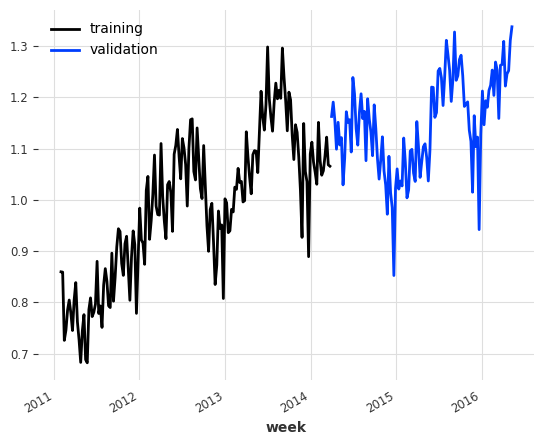

In [292]:
# Plot the data
train.plot(label="training")
val.plot(label="validation")

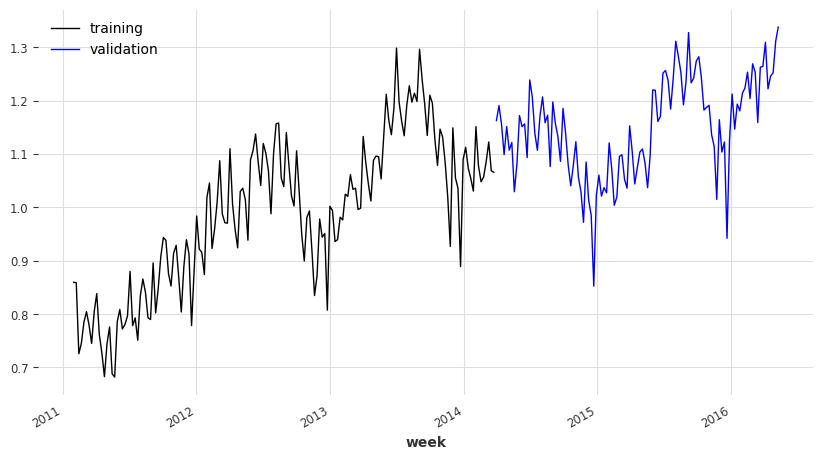

In [303]:
# Plot the data
fig,ax = plt.subplots(figsize=(10,5))
train.plot(label="training", ax=ax, color='black', linewidth=1)
val.plot(label="validation", ax=ax, color='blue', linewidth=1)

### Checking for Seasonality

In [305]:
# Check Seasonality
from darts.utils.statistics import check_seasonality

# Check for seasonality with default values
# max_lag=24, alpha = 0.5 and m is inferred.
check_seasonality(train)

(True, 4)

In [307]:
# Even at an alpha of 0.01, seasonality is present
check_seasonality(train, max_lag = 104, m=4, alpha = 0.01)

(True, 4)

In [309]:
# No seasonality every for every 5th week.
check_seasonality(train, max_lag = 104, m=5)

(False, 5)

### Extracting trend and seasonality

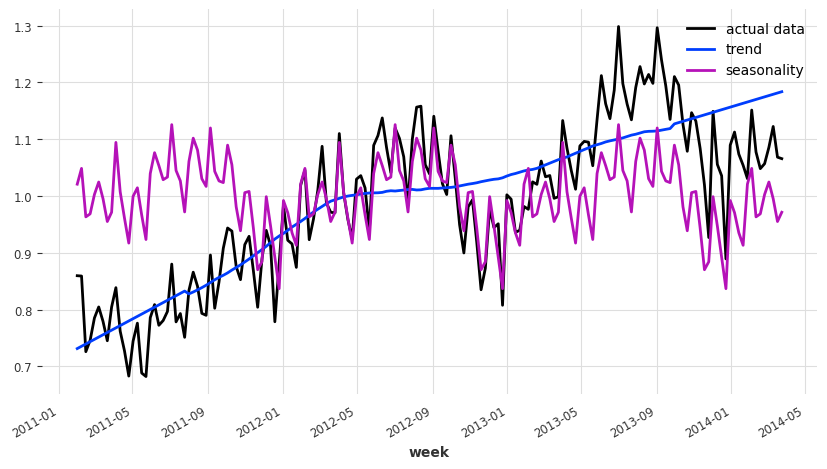

In [311]:
# Extract trend and seasonality
from  darts.utils.statistics import extract_trend_and_seasonality
trend, seasonality = extract_trend_and_seasonality(train)

fig,ax = plt.subplots(figsize=(10,5))
train_california.plot(label = 'actual data', ax=ax)
trend.plot(label = 'trend', ax=ax)
seasonality.plot(label = 'seasonality',ax=ax)

### Testing stationarity

In [321]:
# Test for stationarity
# Null hypothesis that a unit root is present in a time series sample
# Alternative hypothesis: Time series is stationary.
# Accept null hypothesis, i.e. time series is not stationary.
from darts.utils.statistics import stationarity_test_adf
stationarity_test_adf(train_california, regression = 'ct')


(-2.4039473611624147,
 0.37752246592072736,
 5,
 159,
 {'1%': -4.016865591239997,
  '5%': -3.438471289152691,
  '10%': -3.1434724577634183},
 -491.1297424632935)

### Remove non-stationarity

(-5.204527702284346,
 8.587481874551968e-05,
 4,
 159,
 {'1%': -4.016865591239997,
  '5%': -3.438471289152691,
  '10%': -3.1434724577634183},
 -482.90621683159316)

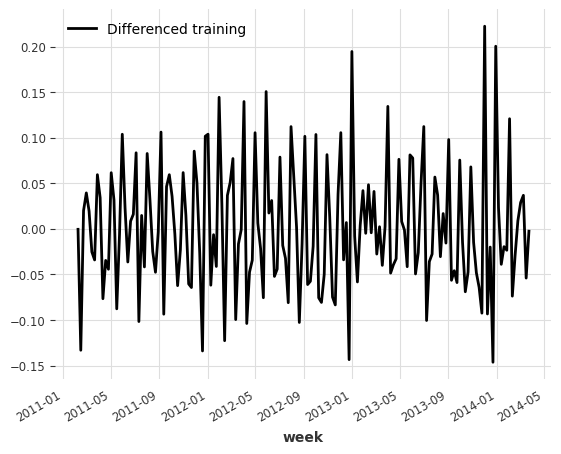

In [328]:
# Differencing to remove stationary
train_diff = train.diff()

train_diff.plot(label="Differenced training")

stationarity_test_adf(train_diff, regression = 'ct')

(-4.798709689652972,
 0.00047083821437737214,
 13,
 147,
 {'1%': -4.021713510530224,
  '5%': -3.44078910993876,
  '10%': -3.144827798366327},
 -424.0772763268649)

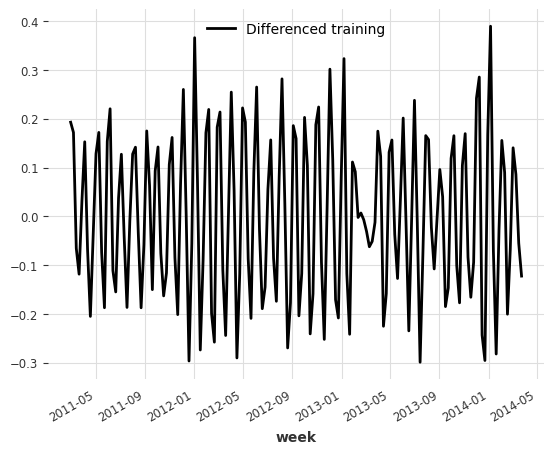

In [329]:
# Differencing to remove stationary
# Here, we do second order differencing
# and take the difference between every other point.
train_diff = train.diff(n=2,periods=2)

train_diff.plot(label="Differenced training")

stationarity_test_adf(train_diff, regression = 'ct')

In [323]:
stationarity_test_adf(train_california_ns, regression='ct')

(-4.124671978514932,
 0.005800992125691049,
 15,
 216,
 {'1%': -4.001305122770125,
  '5%': -3.431014101183445,
  '10%': -3.139106717487807},
 -720.7135298826563)

### Plot Auto-correlation

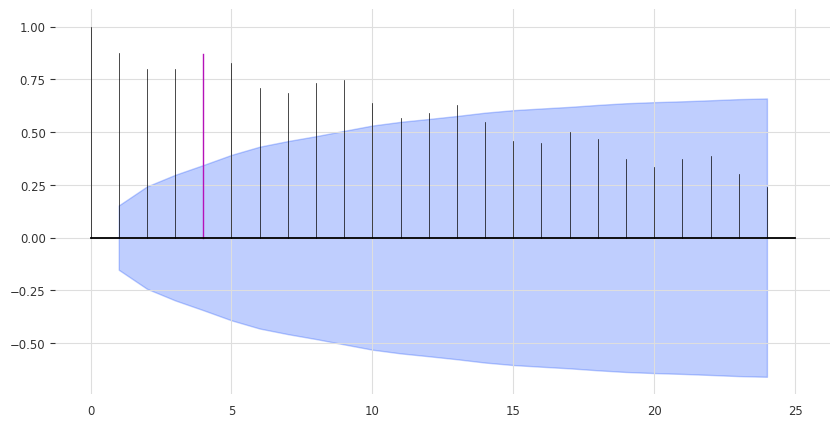

In [451]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=4, alpha=0.05)

## Modeling

### Naive modeling

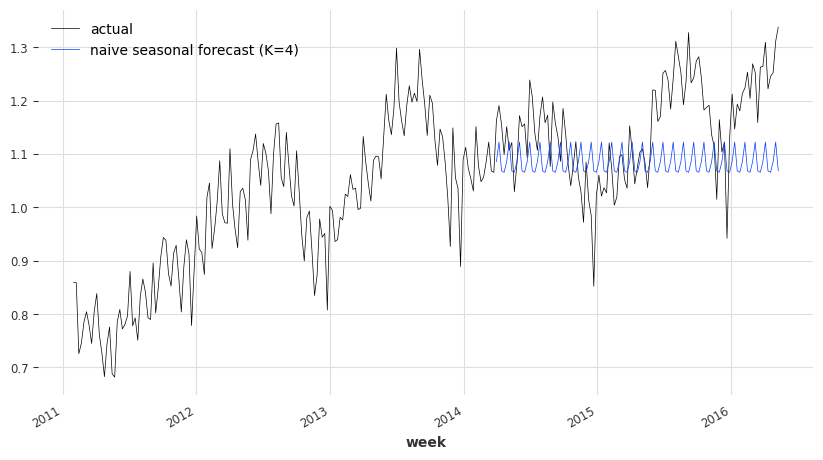

In [445]:
from darts.models import NaiveSeasonal
import matplotlib.pyplot as plt

naive_model = NaiveSeasonal(K=4)
naive_model.fit(train)
naive_seasonal_forecast = naive_model.predict(num_predictions)

fig,ax = plt.subplots(figsize = (10,5))
series.plot(label="actual", linewidth = 0.5, ax=ax)
naive_seasonal_forecast.plot(label="naive seasonal forecast (K=4)", linewidth=0.5,ax=ax)



In [446]:
from darts.metrics import mape

# Find MAPE
MAPE = mape(series, naive_seasonal_forecast)
print(f"naive_seasonal_forecast(K=4) MAPE: {MAPE:.2f}%")

naive_seasonal_forecast(K=4) MAPE: 7.75%


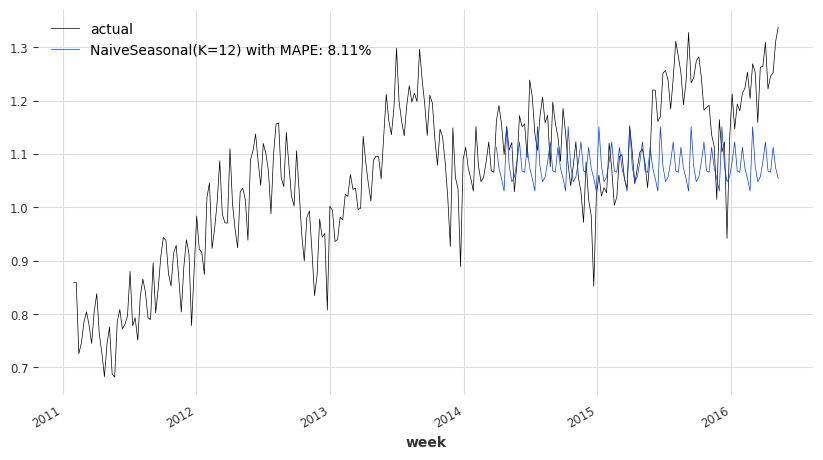

In [447]:
def test_model(model, name):
    # Fit model
    model.fit(train)
    forecast = model.predict(num_predictions)
  
    # Calculate MAPE
    MAPE = mape(series, forecast)

    # Plot graph
    fig,ax = plt.subplots(figsize = (10,5))
    series.plot(label="actual", linewidth = 0.5, ax=ax)
    forecast.plot(label=f"{name} with MAPE: {MAPE:.2f}%", linewidth=0.5,ax=ax)

# Test out Naive Seasonal (K=12)
test_model(NaiveSeasonal(K=12), "NaiveSeasonal(K=12)")

### Naive Drift

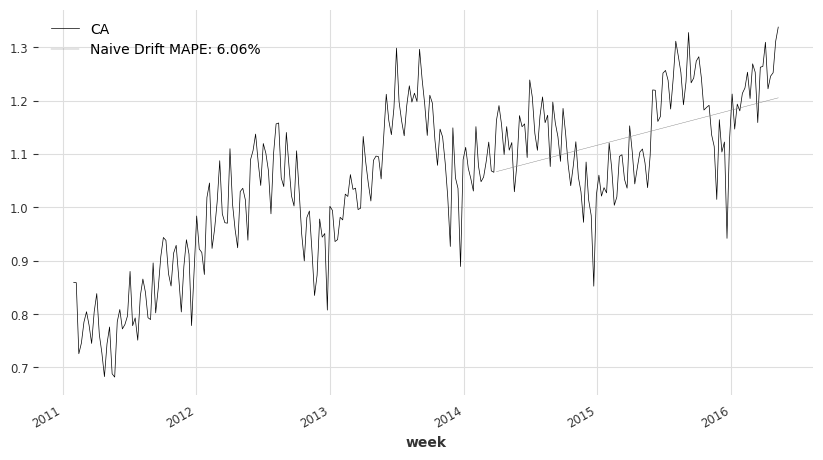

In [448]:
from darts.models import NaiveDrift

# Train a naive drift model
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(num_predictions)

# Calculate MAPE
MAPE = mape(series, drift_forecast)

# Plot graph
fig,ax = plt.subplots(figsize = (10,5))
series_california.plot(linewidth = .5, ax=ax)
drift_forecast.plot(label=f"Naive Drift MAPE: {MAPE:.2f}%", linewidth=.3, ax=ax, color = 'grey')



### Naive Drift + Naive Seasonality

In [492]:
naive_seasonal_forecast['sales']


KeyboardInterrupt



In [499]:
naive_seasonal_forecast['sales'].pd_dataframe().max()

component
sales    1.12245
dtype: float64

In [506]:
naive_seasonal_forecast_amplitude['sales']

0.028344999999999954

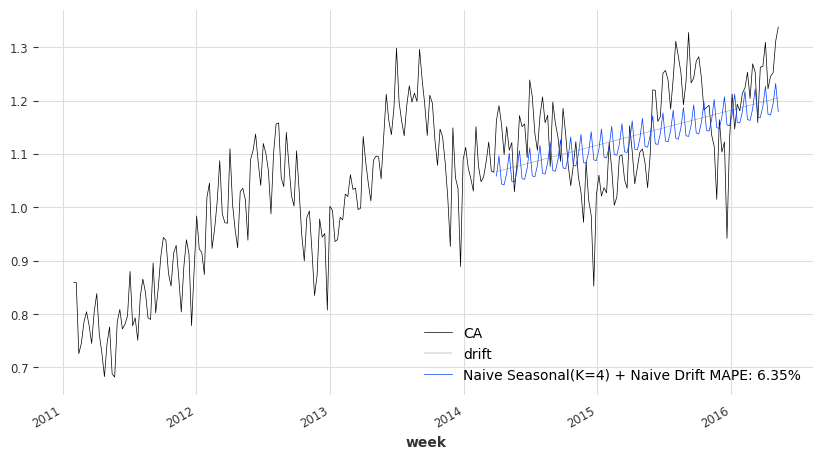

In [507]:
from darts.models import NaiveDrift

# Train a naive drift model
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(num_predictions)

# Combine drift and seasonal predict
# Make sure that fluctuation occurs around the trend
naive_seasonal_forecast_amplitude = ((naive_seasonal_forecast['sales'].pd_dataframe().max() - naive_seasonal_forecast['sales'].pd_dataframe().min()) / 2)['sales']
combined_forecast = drift_forecast + naive_seasonal_forecast - train.last_value() - naive_seasonal_forecast_amplitude

# Calculate MAPE
MAPE = mape(series, combined_forecast)

# Plot graph
fig,ax = plt.subplots(figsize = (10,5))
series_california.plot(linewidth = .5, ax=ax)
drift_forecast.plot(label="drift", linewidth=.3, ax=ax, color = 'grey')
combined_forecast.plot(label=f"Naive Seasonal(K=4) + Naive Drift MAPE: {MAPE:.2f}%", linewidth=0.5,ax=ax)



### AutoArima

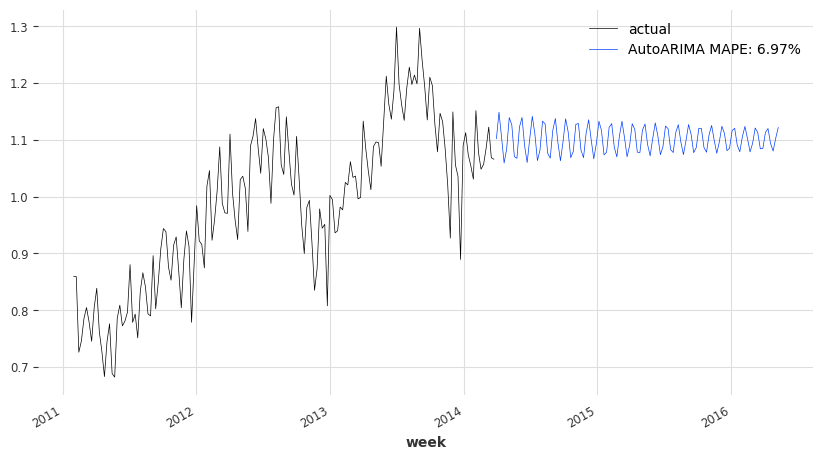

In [393]:
from darts.models.forecasting.auto_arima import AutoARIMA

# Train model on AutoARIMA
autoarima = AutoARIMA()
autoarima.fit(train)

# Make predictions
autoarima_forecast_california = autoarima.predict(n=num_predictions)

# Calculate MAPE
MAPE = mape(series, autoarima_forecast_california)

# Plot graph
fig,ax = plt.subplots(figsize = (10,5))
train_california.plot(label="actual", linewidth = 0.5 ,ax=ax)
autoarima_forecast_california.plot(label=f"AutoARIMA MAPE: {MAPE:.2f}%", linewidth=0.5, ax=ax)


### Prophet (with monthly seasonality)

18:29:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:47 - cmdstanpy - INFO - Chain [1] done processing


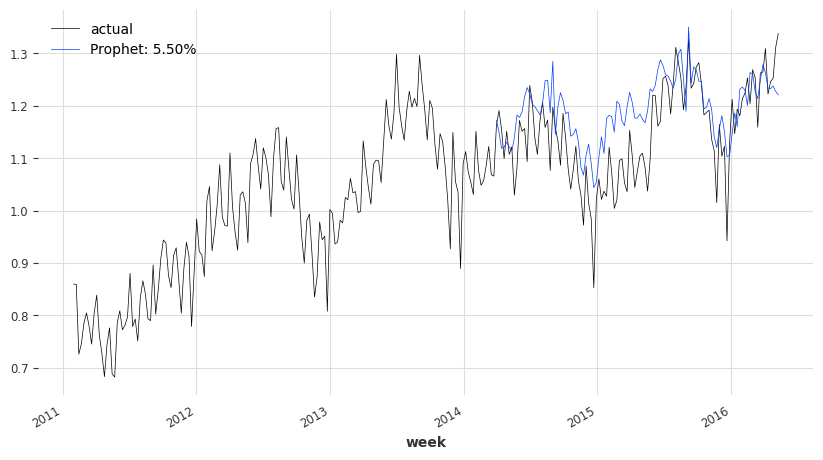

In [452]:
from darts.models import Prophet

# Train on default Prophet
# prophet_model = Prophet()

# Train on Prophet with added seasonality and country
prophet_model = Prophet(add_seasonalities=[{'name': 'monthly', 'seasonal_periods':4, 'fourier_order':2}],
                       country_holidays = 'US')
prophet_model.fit(train)

# Make predictions
prophet_forecast_california = prophet_model.predict(n=num_predictions)

# Calculate MAPE
MAPE = mape(series, prophet_forecast_california)

fig,ax = plt.subplots(figsize = (10,5))
series.plot(label="actual", linewidth = 0.5 ,ax=ax)
prophet_forecast_california.plot(label=f"Prophet: {MAPE:.2f}%", linewidth=0.5, ax=ax)

### Prophet (with monthly and yearly seasonality)

18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing


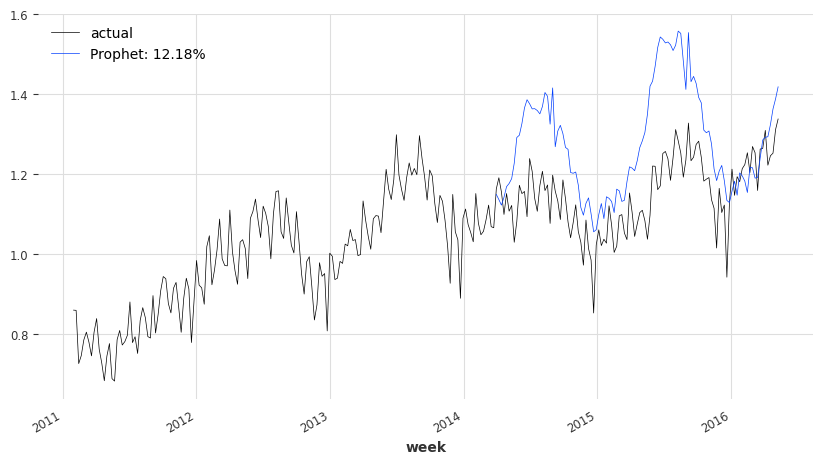

In [453]:
from darts.models import Prophet

prophet_model = Prophet(add_seasonalities=[{'name': 'monthly', 'seasonal_periods':4, 'fourier_order':2},
                                          {'name': 'yr', 'seasonal_periods':52, 'fourier_order':2}],
                       country_holidays = 'US')
prophet_model.fit(train_california)
prophet_forecast_california = prophet_model.predict(num_predictions)

# Calculate MAPE
MAPE = mape(series, prophet_forecast_california)

fig,ax = plt.subplots(figsize = (10,5))
series.plot(label="actual", linewidth = 0.5 ,ax=ax)
prophet_forecast_california.plot(label=f"Prophet: {MAPE:.2f}%", linewidth=0.5, ax=ax)

## RNN Model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 202 K 
4 | V             | Linear           | 101   
---------------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
1.623     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

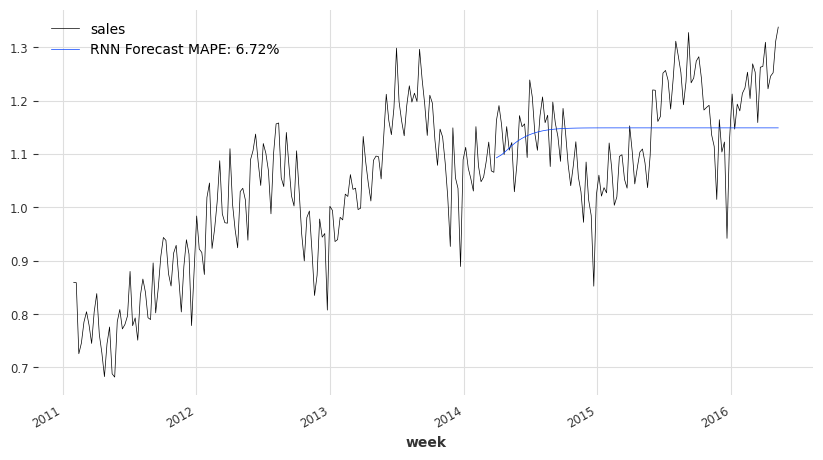

In [435]:
from darts.models import RNNModel

seasonal_period = 4 #weeks

# Train Default RNN Model.
# Note that you must specify input_chunk_length manually.
# rnn_model = RNNModel(input_chunk_length=seasonal_period*2)

# Specify more parameters in RNN
rnn_model = RNNModel(input_chunk_length=seasonal_period*32, # Set input_chunk_length to 32*4 weeks = 8months so the model can see past 8 months of data to make one week of prediction.
                     model='LSTM', # Use LSTM instead of RNN so the model has better long-term memory
                     hidden_dim=100, # Decrease the number of hidden diemnsions for a small problem
                     n_rnn_layers=3, # Limit the number of hidden layers for this small problem
                     dropout=0.2, # Dropout 20% of the neurons at training in order to regularize the model
                     n_epochs=200 # Set high number of epochs for training to ensure that model has trained to completion.
                    )
rnn_model.fit(train)
rnn_forecast = rnn_model.predict(num_predictions)

# Calculate MAPE
MAPE = mape(series, rnn_forecast)

# Plot graph
fig,ax = plt.subplots(figsize = (10,5))
series.plot(linewidth = .5, ax=ax)
rnn_forecast.plot(label=f"RNN Forecast MAPE: {MAPE:.2f}%", linewidth=0.5,ax=ax)


In [434]:
rnn_model.residuals

<bound method ForecastingModel.residuals of <darts.models.forecasting.rnn_model.RNNModel object at 0x7fb489a36f70>>

## TCN Model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 272   
----------------------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

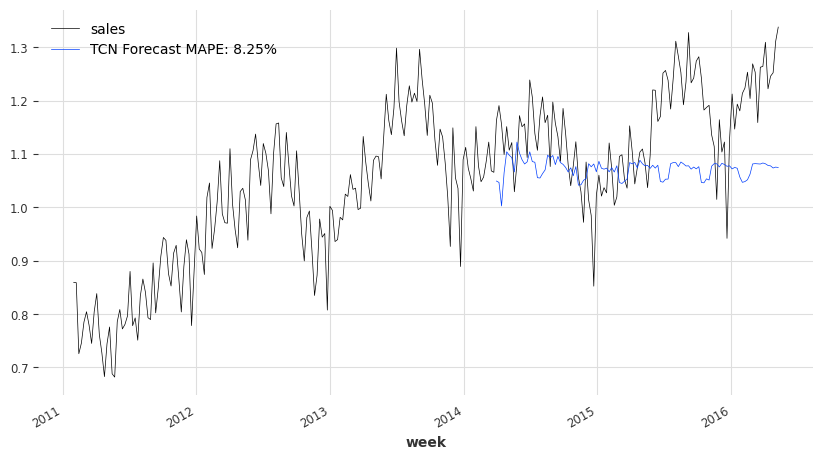

In [443]:
from darts.models import TCNModel

seasonal_period = 4 #weeks

# Train Default TCN Model.
# Note that you must specify input_chunk_length and output_chunk_length manually.
# rnn_model = RNNModel(input_chunk_length=seasonal_period*16,
#                      output_chunk_length=seasonal_period*4
#                      )

# Specify more parameters in TCN
tcn_model = TCNModel(input_chunk_length=seasonal_period*16, # Set input_chunk_length to 16/4 weeks = 4months so the model can see past 1 months of data
                     output_chunk_length=seasonal_period*4, # Make 4 weeks of prediction at one go.
                     dropout=0.1, # Dropout 20% of the neurons at training in order to regularize the model
                     n_epochs=200 # Set high number of epochs for training to ensure that model has trained to completion.
                    )
tcn_model.fit(train)
tcn_forecast = tcn_model.predict(num_predictions)

# Calculate MAPE
MAPE = mape(series, tcn_forecast)

# Plot graph
fig,ax = plt.subplots(figsize = (10,5))
series.plot(linewidth = .5, ax=ax)
tcn_forecast.plot(label=f"TCN Forecast MAPE: {MAPE:.2f}%", linewidth=0.5,ax=ax)


## Transformer Model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 1.0 K 
------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
4.398     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

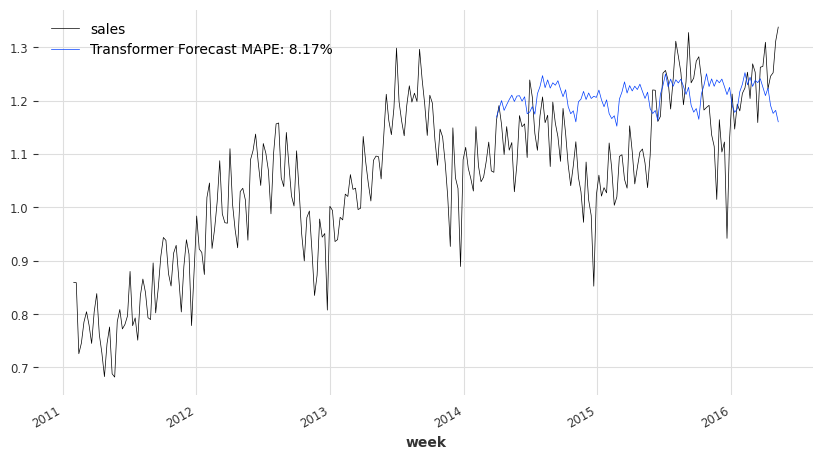

In [444]:
from darts.models import TransformerModel

seasonal_period = 4 #weeks

# Train Default TransformerModel.
# Note that you must specify input_chunk_length and output_chunk_length manually.
# transformer_model = TransformerModel(input_chunk_length=seasonal_period*16,
#                      output_chunk_length=seasonal_period*4
#                      )

# Specify more parameters in TCN
transformer_model = TransformerModel(input_chunk_length=seasonal_period*16, # Set input_chunk_length to 16/4 weeks = 4months so the model can see past 1 months of data
                             output_chunk_length=seasonal_period*4, # Make 4 weeks of prediction at one go.
                             dropout=0.1, # Dropout 20% of the neurons at training in order to regularize the model
                             n_epochs=200 # Set high number of epochs for training to ensure that model has trained to completion.
                            )
transformer_model.fit(train)
transformer_forecast = transformer_model.predict(num_predictions)

# Calculate MAPE
MAPE = mape(series, transformer_forecast)

# Plot graph
fig,ax = plt.subplots(figsize = (10,5))
series.plot(linewidth = .5, ax=ax)
transformer_forecast.plot(label=f"Transformer Forecast MAPE: {MAPE:.2f}%", linewidth=0.5,ax=ax)
